# Avellaneda-Stoikov agent vs RL agent

### Import external modules

In [49]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import os

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [50]:
import sys
sys.path.append("../")

In [ ]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, RunningInventoryPenalty
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics

### Initialize environment

In [52]:
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
seed = 50

In [53]:
initial_price = 100
terminal_time = 1.0
sigma = 2.0
n_steps = 200
initial_inventory = 0
arrival_rate = 140
fill_exponent = 1.5

# Reward function parameters
phi = 0.5
alpha = 0.001

In [54]:
def get_as_env(num_trajectories:int = 1):
    midprice_model = BrownianMotionMidpriceModel(initial_price = initial_price, 
                                                 volatility=sigma, step_size=1/n_steps,
                                                 terminal_time = terminal_time,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)

    reward_function = RunningInventoryPenalty(
        per_step_inventory_aversion = phi,
        terminal_inventory_aversion = alpha
    )

    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      seed = seed,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function=reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [55]:
num_trajectories = 1000
env = ReduceStateSizeWrapper(get_as_env(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [56]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-AS/"
best_model_path = "./SB_models/PPO-best-AS.zip"

### Define PPO policy

In [57]:
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [58]:
# Train model or load pretrained

OVERWRITE = False

if OVERWRITE or not os.path.isfile(best_model_path):
    print("Training from scratch")
    model.learn(
        # total_timesteps = 10_000_000
        total_timesteps = 20_000_000
    )  # Increase number of training timesteps according to computing resources
    model.save(best_model_path)
else:
    print("Loading best model")
    model = PPO.load(best_model_path)
    model.env = sb_env

Loading best model


## Comparing the learnt policy to the optimal policy

In [59]:
from mbt_gym.agents.SbAgent import SbAgent

In [60]:
ppo_agent = SbAgent(model)

In [61]:
inventories = np.arange(-3,4,1)
bid_actions = []
ask_actions = []
for inventory in inventories:
    bid_action, ask_action = ppo_agent.get_action(np.array([[inventory,0.5]])).reshape(-1)
    bid_actions.append(bid_action)
    ask_actions.append(ask_action)    

In [67]:
from mbt_gym.agents.BaselineAgents import *

as_env = get_as_env()
as_agent = AvellanedaStoikovAgent(risk_aversion=0.1, env=as_env)

In [ ]:
# Get the Avellaneda-Stoikov agent action

as_bid_actions = []
as_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = as_agent.get_action(np.array([[0,inventory,0.5]])).reshape(-1)
    as_bid_actions.append(bid_action)
    as_ask_actions.append(ask_action)

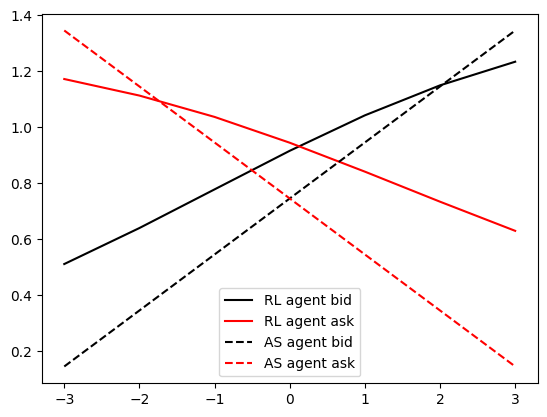

In [64]:
plt.plot(inventories, bid_actions, label = "RL agent bid", color = "k")
plt.plot(inventories, ask_actions, label = "RL agent ask", color = "r")
plt.plot(inventories, as_bid_actions, label = "AS agent bid", color = "k", linestyle = "--")
plt.plot(inventories, as_ask_actions, label = "AS agent ask", color = "r", linestyle = "--")
plt.legend()